In [3]:
import os
from pathlib import Path

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
from load_data import load_data
from rsl_depth_completion.conditional_diffusion.config import cfg
from rsl_depth_completion.conditional_diffusion.utils import log_params_to_exp
from rsl_depth_completion.diffusion.utils import set_seed

set_seed(cfg.seed)
torch.backends.cudnn.benchmark = True

if cfg.is_cluster:
    if not os.path.exists(f"{cfg.tmpdir}/cluster"):
        os.system(f"tar -xvf /cluster/project/rsl/kzaitsev/dataset.tar -C {cfg.tmpdir}")

import itertools
import shutil


def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))
from rsl_depth_completion.conditional_diffusion.config import cfg
ds_params_full = product_dict(
    use_text_embed=[True, False],
    use_cond_image=[True, False],
    use_rgb_as_cond_image=[True, False],
)
ds_params = [
    list(ds_params_full)[-1]
]
ds_params
for ds_name in ["mnist"]:
    for ds_kwargs in ds_params:
        ds_kwargs["use_rgb_as_text_embed"] = not ds_kwargs["use_rgb_as_cond_image"]
        ds_kwargs["include_sdm_and_rgb_in_sample"] = True
        ds_kwargs["do_crop"] = True
        print(ds_kwargs)

        ds, train_dataloader, val_dataloader = load_data(
            ds_name=ds_name, do_debug=cfg.do_debug, **ds_kwargs
        )

Found cached dataset fashion_mnist (/media/master/wext/cv_data/hf_home/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

{'use_text_embed': False, 'use_cond_image': False, 'use_rgb_as_cond_image': False, 'use_rgb_as_text_embed': True, 'include_sdm_and_rgb_in_sample': True, 'do_crop': True}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:46                                                                                   │
│                                                                                                  │
│   43 │   │   print(ds_kwargs)                                                                    │
│   44 │   │                                                                                       │
│   45 │   │   ds, train_dataloader, val_dataloader = load_data(                                   │
│ ❱ 46 │   │   │   ds_name=ds_name, do_debug=cfg.do_debug, **ds_kwargs                             │
│   47 │   │   )                                                                                   │
│   48                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: type object 'cfg' has no attribute 'do_debug'

In [4]:
from imagen_pytorch import Unet, Imagen, ImagenTrainer
from imagen_pytorch.data import Dataset

import gc;
gc.collect()
torch.cuda.empty_cache()

# unets for unconditional imagen

unet = Unet(
    dim = 128,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 1,
    layer_attns = (False, False, False, True),
    layer_cross_attns = False
)

# imagen, which contains the unet above

imagen = Imagen(
    condition_on_text = False,  # this must be set to False for unconditional Imagen
    unets = unet,
    image_sizes = 64,
    timesteps = 200,
    channels=1
)

trainer = ImagenTrainer(
    imagen = imagen,
    lr=1e-4,
    split_valid_from_train = False # whether to split the validation dataset from the training
).cuda()

# instantiate your dataloader, which returns the necessary inputs to the DDPM as tuple in the order of images, text embeddings, then text masks. in this case, only images is returned as it is unconditional training

# dataset = Dataset('/path/to/training/images', image_size = 128)

In [84]:
# working training loop

from tqdm.auto import tqdm


if True:
    data_gen = enumerate(train_dataloader)
else:
    data_gen = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    )
batch = next(data_gen)[1]
images = batch["image"].to(cfg.device)
for i in tqdm(range(2000)):
    # for batch_idx, batch in data_gen:
    #     if "text_embed" in batch:
    #         text_embeds = batch["text_embed"].to(cfg.device)
    #     else:
    #         text_embeds = None
    #     if "cond_image" in batch:
    #         cond_images = batch["cond_image"].to(cfg.device)
    #     else:
    #         cond_images = None
    loss = trainer(images, unet_number = 1)
    trainer.update(unet_number = 1)
    print(f'loss: {loss}')

# if not (i % 50):
#     valid_loss = trainer.valid_step(unet_number = 1, max_batch_size = 4)
#     print(f'valid loss: {valid_loss}')

# if not (i % 100) and trainer.is_main: # is_main makes sure this can run in distributed
#     images = trainer.sample(batch_size = 1, return_pil_images = True) # returns List[Image]
#     images[0].save(f'./sample-{i // 100}.png')

  0%|          | 0/2000 [00:00<?, ?it/s]

loss: 0.9885436296463013
loss: 0.9863346219062805
loss: 1.0143909454345703
loss: 1.006633996963501
loss: 0.24631746113300323
loss: 0.6914851665496826
loss: 0.9556206464767456
loss: 0.926720142364502
loss: 0.8720002174377441
loss: 0.8272785544395447
loss: 0.7518694400787354
loss: 0.1970551759004593
loss: 0.6812911629676819
loss: 0.001914554857648909
loss: 0.6401550769805908
loss: 0.5885323286056519
loss: 0.6031114459037781
loss: 0.4766201972961426
loss: 0.5463262796401978
loss: 0.4566729664802551
loss: 0.04445219784975052
loss: 0.3012121617794037
loss: 0.01720673032104969
loss: 0.32802850008010864
loss: 0.18479733169078827
loss: 0.16964390873908997
loss: 0.15633505582809448
loss: 0.13765278458595276
loss: 0.020056145265698433
loss: 0.07084724307060242
loss: 0.022322682663798332
loss: 0.20472140610218048
loss: 0.0978069007396698
loss: 0.14250122010707855
loss: 0.14793896675109863
loss: 0.15699295699596405
loss: 0.13847537338733673
loss: 0.024053435772657394
loss: 0.14834696054458618
loss

In [88]:
print(sum(p.numel() for p in trainer.parameters() if p.requires_grad))

153030290


In [85]:
import matplotlib.pyplot as plt


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

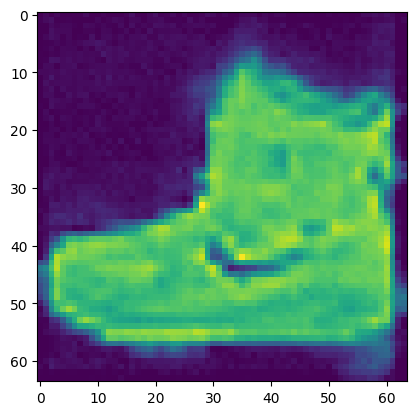

In [86]:
samples = trainer.sample(batch_size = 1, return_pil_images = True)
plt.imshow(samples[0])

Text(0.5, 1.0, 'original')

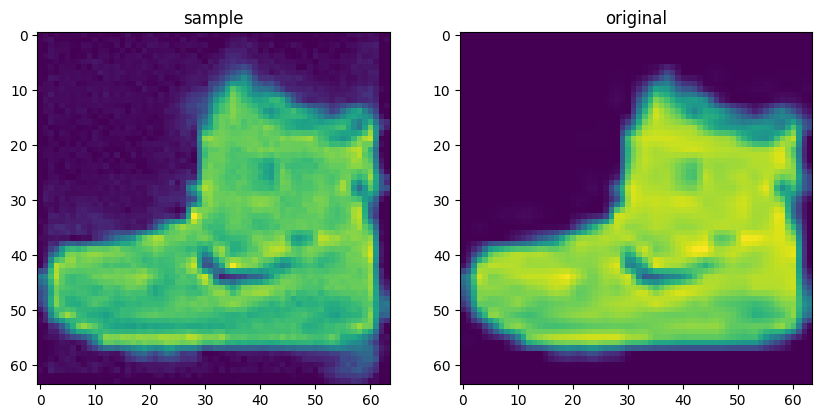

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(samples[0])
ax[0].set_title("sample")
ax[1].imshow(images[0].cpu().numpy().squeeze())
ax[1].set_title("original")

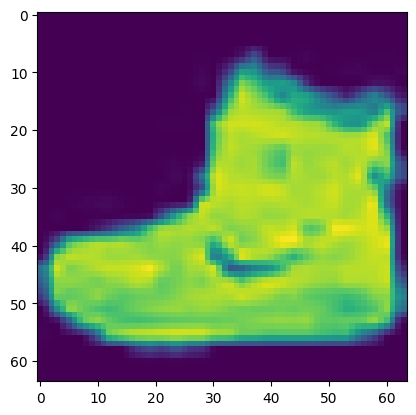

In [18]:

plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())